# level-1 P-stage EDA

## input 분석
우선 이번 과제의 데이터는 다음과 같다.

마스크를 착용하는 건 COIVD-19의 확산을 방지하는데 중요한 역할을 합니다. 제공되는 이 데이터셋은 사람이 마스크를 착용하였는지 판별하는 모델을 학습할 수 있게 해줍니다. 모든 데이터셋은 아시아인 남녀로 구성되어 있고 나이는 20대부터 70대까지 다양하게 분포하고 있습니다. 간략한 통계는 다음과 같습니다.

전체 사람 명 수 : 4,500

한 사람당 사진의 개수: 7 [마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장]

이미지 크기: (384, 512)

전체 데이터셋 중에서 60%는 학습 데이터셋으로 활용됩니다.

>레퍼런스: https://stages.ai/competitions/104/discussion/talk/post/1104

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
data = pd.read_csv('../data/train/train.csv')

In [5]:
data.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [6]:
data.isnull().sum() # null 값이 있는지 확인

id        0
gender    0
race      0
age       0
path      0
dtype: int64

In [7]:
# 대회에서 요구하는 연령대로 구분한 컬럼을 추가한다.
def get_age_range(age):
    if age<30:
        return '< 30'
    elif age>=30 and age<60:
        return '>= 30 and < 60'
    elif age>=60:
        return '>= 60'

data['age_range']=data['age'].apply(lambda x: get_age_range(x))

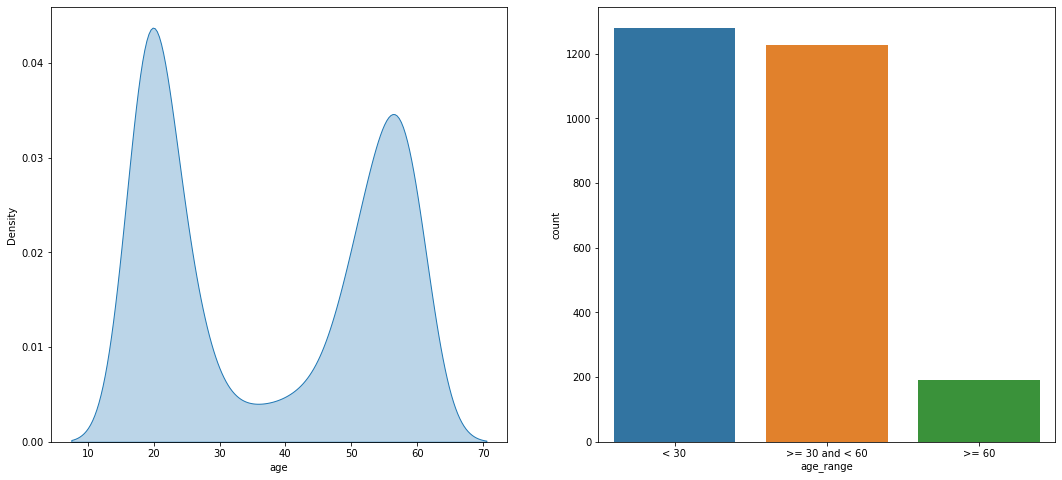

In [8]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 나이
#sns.countplot('age', data=data, ax=ax[0] )
g1 = sns.kdeplot(data=data, x='age', fill=True, alpha=0.3, ax=ax[0])
g2 = sns.countplot(data=data, x='age_range', ax=ax[1], order=['< 30', '>= 30 and < 60', '>= 60'])

# 성별
#data['gender'].value_counts().plot.pie()
#ax[1].set_title('Gender')

plt.show()

Text(0, 0.5, '')

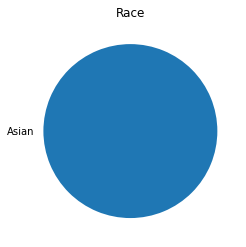

In [9]:
f2 = data['race'].value_counts().plot.pie()
f2.set_title('Race')
f2.set_ylabel('')

학습 데이터의 분포를 살펴보자. 학습 데이터의 'feature'에는 성별과 나이, 인종이 있다. 각 특성별로 데이터를 살펴보겠다.


- 성별의 경우에는 여성의 비율이 조금 더 높은 것을 알 수 있다. 이는 남성에 대한 이미지 분석 예측이 다소 어긋날 수 있을 수도 있지만, 비율의 차이가 크지 않으므로 큰 문제가 될 것 같지는 않다.

- 연령의 경우에는 1020의 비율과 50의 비율이 높고 3040대의 비율은 상대적으로 적은 모습을 알 수 있다. 연령대가 편중되어 있는 만큼 모델의 예측 결과가 특정 연령대에서는 부정확할 수 있다는 점이 예상된다.

- 인종의 경우에는 모두 Asian으로 학습된 모델이 타 인종의 대해서 어떤 예측치를 내놓을 지는 미지수이다. 잘 작동할 수도 있지만, 오차가 클 수도 있다.

그렇다면, 성별을 고려한 연령대의 분포도 불균형이 존재하는지 확인해보자. 이를 위해 `hue` parameter를 사용해볼 수 있다.

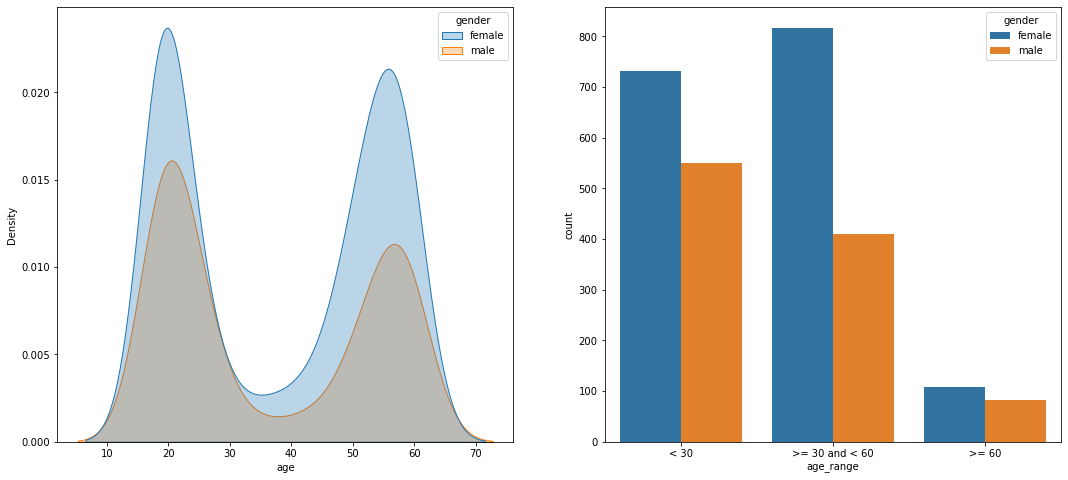

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 성별 별 분포 확인
g1 = sns.kdeplot(data=data, x='age', hue='gender', fill=True, alpha=0.3, ax=ax[0])
g2 = sns.countplot(data=data, x='age_range', hue='gender', ax=ax[1], order=['< 30', '>= 30 and < 60', '>= 60'])


성별에 따른 연령 분포의 경우 큰 차이를 보이지는 않는다. 다만, 여전히 30~60세 사이의 구간은 다소 불균형한 상태로 보인다.

## Target 분석

다음으로는 taget이 될 y에 대한 분석을 해볼 것이다. 이번 과제에서 요구하는 결과값은 다음과 같다.


결과값. 총 18개의 class를 예측해야합니다. 결과값으로 0~17에 해당되는 숫자가 각 이미지 당 하나씩 나와야합니다.
예시:
7 (the class of cfe1268.jpg)
2 (the class of 3a2662c.jpg)
…

Class Description:
마스크 착용여부, 성별, 나이를 기준으로 총 18개의 클래스가 있습니다.

간단히 요약하면...

- Mask: Wear, Incorrect, Not Wear
- Gender: Male, Female
- Age: <30, >=30 and <60, >=60
으로 (3, 2, 3)가지 이다.

Text(0, 0.5, 'count')

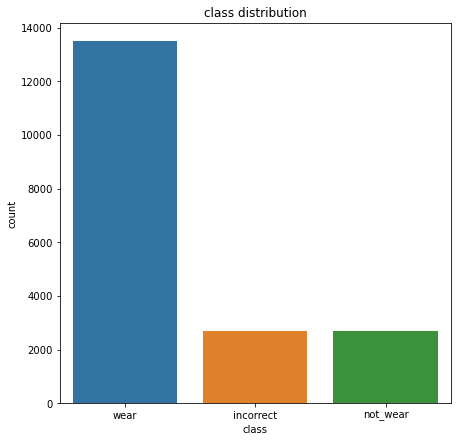

In [11]:
total = len(data) * 7
labels = ['wear', 'incorrect', 'not_wear']
val = [len(data)*5, len(data)*1, len(data)*1]

f, ax = plt.subplots(1,1, figsize=(7,7))
g = sns.barplot(x=labels, y=val)

ax.set_title('class distribution')
ax.set_xlabel('class')
ax.set_ylabel('count')

위의 경우에서 보듯, 마스크 착용 데이터가 다른 데이터 대비 약 5배를 차지하고 있다. 이를 고려하여 마스크를 착용하지 않은 케이스나, 잘못 착용한 케이스에 대한 Data augmentaion을 고려해볼 수 있음.

<hr>

# 개별 데이터 분석

설명에 따르면, 개별 데이터 하나는 총 7장의 이미지로 구성된다. 마스크를 착용한 사진 5장과 잘못 착용한 사진 1장, 그리고 쓰지 않은 사진 1장이다. 대표로 이미지 한장을 가져와서 살펴보겠다.

In [20]:
import os

sample = data.sample()

sample_img_path = sample.path.values[0]
#print(sample_img_path)
sample_img_list = [img for img in os.listdir('../data/train/images/'+sample_img_path) if '._' not in img]
sample_img_list.sort()

In [ ]:
import cv2


fig = plt.figure(figsize=(18, 8))

for i, filename in enumerate(sample_img_list):
    img_path = '../data/train/images/' + sample_img_path + '/' + filename
    img = cv2.imread(img_path)
    ax = fig.add_subplot(2, 4, i+1)
    
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(filename.split('.')[0])


plt.show()

## class별 이미지 샘플
각 클래스별로 5개의 샘플 이미지를 가져와서 확인해보자.

In [14]:
sample = data.sample(5)
sample_img_path = sample.path.values
img_list = []

for img in sample_img_path:
    lists = []
    imgs = [img for img in os.listdir('../data/train/images/'+img) if '._' not in img]
    
    for d in imgs:
        path = '../data/train/images/'+img+'/'+d
        img_kind = d.split('.')[0]
        lists.append(path)
    
    lists.sort()
    img_list.append(lists)

In [ ]:
fig = plt.figure(figsize=(35,20))

i = 1

for files in img_list:
    for filename in files:
        img = cv2.imread(filename)
        ax = fig.add_subplot(5, 7, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        if i<8:
            ax.set_title(filename.split('/')[-1].split('.')[0], fontsize=25)
        i+=1

plt.tight_layout()
plt.show()

incorrect_mask의 경우 대부분 턱스크를 한 모습이지만, 간혹 다른 착용 모습을 보여주기도 한다. 조금 더 자세히 살펴보기 위해 incorrect_mask case만 대량으로 추출하여 살펴보자.

In [35]:
sample = data.sample(30)
sample_img_path = sample.path.values
img_list = []

for img in sample_img_path:
    lists = []
    imgs = [img for img in os.listdir('../data/train/images/'+img) if '._' not in img]

    for d in imgs:
        if d == 'incorrect_mask.jpg':
            path = '../data/train/images/'+img+'/'+d
            img_kind = d.split('.')[0]
            lists.append(path)
    
    lists.sort()
    img_list.append(lists)


In [ ]:
fig = plt.figure(figsize=(35,35))

i = 1

for files in img_list:
    for filename in files:
        img = cv2.imread(filename)
        ax = fig.add_subplot(5, 7, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        if i<8:
            ax.set_title(filename.split('/')[-1].split('.')[0], fontsize=25)
        i+=1

plt.tight_layout()
plt.show()

일부 사진에서 보이듯이 '코스크'를 하는 경우도 종종 있으며, 심지어는 눈까지 가린.... 잘못된 착용 사례가 존재한다. 턱스크 외의 비중이 상당히 적으므로 이 부분이 향후 모델의 performence에 영향을 미칠 수도 있다. 

종합하자면 사진 데이터의 편향을 크게 3가지 뽑아볼 수 있는데

- incorrect_mask와 no_mask의 숫자가 적음
- incorrect_mask의 사례가 일관적이지 않음
- 사진의 밝기, 배경이 다양함. 특히 배경의 경우 복잡한 배경을 뒤로하고 찍은 사진도 일부 존재함